# **Clustering the Data**

## Objectives

* Determine if an Investigate the data using clustering algoritthms to investigate our hypothesis # something

## Inputs

* `'game_data_clean'` from notebook 02. 

## Outputs

* A clustering model and some analysis of the underlying dataset.

## Additional Comments
* This notebook follow the analysis done in notebook 07 of the Churnometer walkthrough project.

---

#### Change working directory

In [51]:
import os

home_dir = '/workspace/pp5-ml-dashboard'
os.chdir(home_dir)
current_dir = os.getcwd()
print(current_dir)

/workspace/pp5-ml-dashboard


We now load our data and prepare it like in notebook 04.

In [52]:
import pandas as pd
import numpy as np
from src.utils import get_df, save_df

game_data = get_df("game_data_clean", "datasets/clean/csv")
game_data.head()

,season_id,team_id_home,team_name_home,wl_home,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,day,month,year
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,21985,1610612737,Atlanta Hawks,L,41.0,92.0,0.0,3.0,9.0,18.0,...,40.0,21.0,11.0,7.0,17.0,19.0,100.0,25,10,1985
28500006,21985,1610612758,Sacramento Kings,L,39.0,88.0,0.0,2.0,26.0,41.0,...,42.0,19.0,7.0,7.0,18.0,32.0,108.0,25,10,1985
28500010,21985,1610612765,Detroit Pistons,W,39.0,88.0,0.0,1.0,40.0,49.0,...,41.0,27.0,10.0,7.0,20.0,32.0,116.0,25,10,1985
28500011,21985,1610612762,Utah Jazz,L,42.0,82.0,0.0,2.0,24.0,38.0,...,47.0,23.0,10.0,7.0,19.0,28.0,112.0,25,10,1985
28500008,21985,1610612744,Golden State Warriors,L,36.0,91.0,0.0,4.0,33.0,52.0,...,44.0,26.0,11.0,3.0,22.0,40.0,119.0,25,10,1985


In [53]:
game_data["home_wins"] = game_data.apply(
    lambda x: 1 if x["wl_home"] == "W" else 0, axis=1
)
game_data["play_off"] = game_data.apply(
    lambda x: 1 if str(x["season_id"])[0] == "4" else 0, axis=1
)
game_data["season"] = game_data.apply(
    lambda x: int((x["season_id"] % 10000) - 1985), axis=1
)

to_drop = ["team_id_home", "team_id_away", "wl_home", "season_id", "day",
           "month", "year", "team_name_home", "team_name_away"]
game_data.drop(labels=to_drop, axis=1, inplace=True)

for col in game_data.columns:
    game_data[col] = game_data[col].astype("int32")

game_data.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off,season
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,41,92,0,3,9,18,16,28,44,25,...,40,21,11,7,17,19,100,0,0,0
28500006,39,88,0,2,26,41,20,28,48,17,...,42,19,7,7,18,32,108,0,0,0
28500010,39,88,0,1,40,49,17,40,57,23,...,41,27,10,7,20,32,116,1,0,0
28500011,42,82,0,2,24,38,10,24,34,30,...,47,23,10,7,19,28,112,0,0,0
28500008,36,91,0,4,33,52,18,29,47,17,...,44,26,11,3,22,40,119,0,0,0


## Section 1: Set up problem
The game of basketball has evolved over the years. For example, we saw in our exploratory data analysis that there was a correlation between 3 pointers and year. We are going to test if clustering will detect the various eras of basketball.

We will then look at the profiles of each cluster to see how it groups games of basketball and try to determine if these clusters have any correlation with time.

In [54]:
game_seasons = game_data.filter(['season'])
game_data.drop(labels=['season'],inplace=True,axis=1)
game_data.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,41,92,0,3,9,18,16,28,44,25,...,29,40,21,11,7,17,19,100,0,0
28500006,39,88,0,2,26,41,20,28,48,17,...,31,42,19,7,7,18,32,108,0,0
28500010,39,88,0,1,40,49,17,40,57,23,...,28,41,27,10,7,20,32,116,1,0
28500011,42,82,0,2,24,38,10,24,34,30,...,30,47,23,10,7,19,28,112,0,0
28500008,36,91,0,4,33,52,18,29,47,17,...,31,44,26,11,3,22,40,119,0,0


Now we construct our pipeline for clustering. The format for the pipeline was inspired by the clustering pipeline in the Churnometer walkthrough project.

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from feature_engine import transformation as vt

TRANSFORM_ASSIGNMENT = {
    'yeo_johnson': ['dreb_away', 'blk_home', 'oreb_away', 'fta_away',
                    'dreb_home', 'ast_home', 'stl_away', 'pts_away',
                    'stl_home', 'reb_away', 'pts_home', 'fgm_away',
                    'oreb_home', 'pf_away', 'pf_home'],
    'box_cox': ['ast_away', 'fta_home']
    }
TRANSFORMS = {'box_cox':(vt.BoxCoxTransformer,False),
              'yeo_johnson':(vt.YeoJohnsonTransformer,False)}

def pipe_v1(thresh=0.7,p_components=50,clusters=50):
    pipe = Pipeline([
        ("corr_selector",
         SmartCorrelatedSelection(method="pearson", threshold=thresh,
                                  selection_method="variance")
        )
    ])
    pipe.fit(game_data)
    dropping = pipe['corr_selector'].features_to_drop_
    new_assignments = gen_assignments(TRANSFORM_ASSIGNMENT, dropping)
    for transform, targets in new_assignments.items():
        if not targets:
            continue
        pipe.steps.append(
            (transform, TRANSFORMS[transform][0](variables=targets))
            )
    pipe.steps.append(('scaler', StandardScaler()))
    pipe.steps.append(("PCA", PCA(n_components=p_components, random_state=42)))
    pipe.steps.append(("model", KMeans(n_clusters=clusters, random_state=42)))
    return pipe

def gen_assignments(assignments:dict, drop:list) -> dict:
    new_assignments = { key: [val for val in value if val not in drop] 
                       for key, value in assignments.items()}
    return new_assignments


We will now try to determine the best number of components and and then the right number clusters.

---

## Section 2: PCA
We start by doing some Principal component analysis.

In [6]:
# to suppress warnings
import warnings
import logging
warnings.filterwarnings("ignore", category=FutureWarning)
logging.captureWarnings(True)
os.environ['PYTHONWARNINGS']='ignore'

pipe = pipe_v1()
pca_pipe = Pipeline(pipe.steps[:-2])
game_data_pca = pca_pipe.fit_transform(game_data)


Now that the data is prepared, we will see which number of components will capture enough of the variability of our dataset.

* The 15 components explain 97.94% of the data 



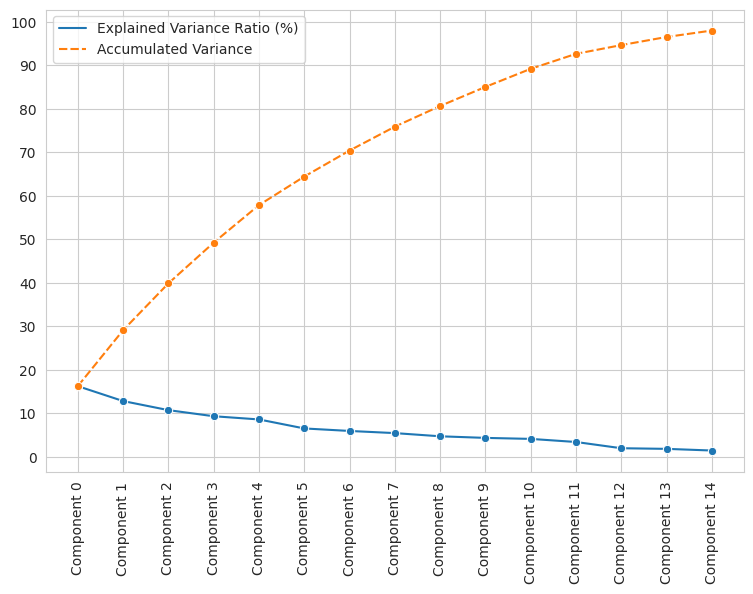

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# This function is from the notebook 07 of the 
# Churnometer walkthrough project.
def pca_component_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)

    ComponentsList = [f"Component {number}"
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )
    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )
    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_component_analysis(game_data_pca, 15)


As we are hoping the data will be grouped into eras, each of which is multiple years long. We expect there to be a fair number of clusters, so we don't mind having many components.

* The 9 components explain 80.61% of the data 



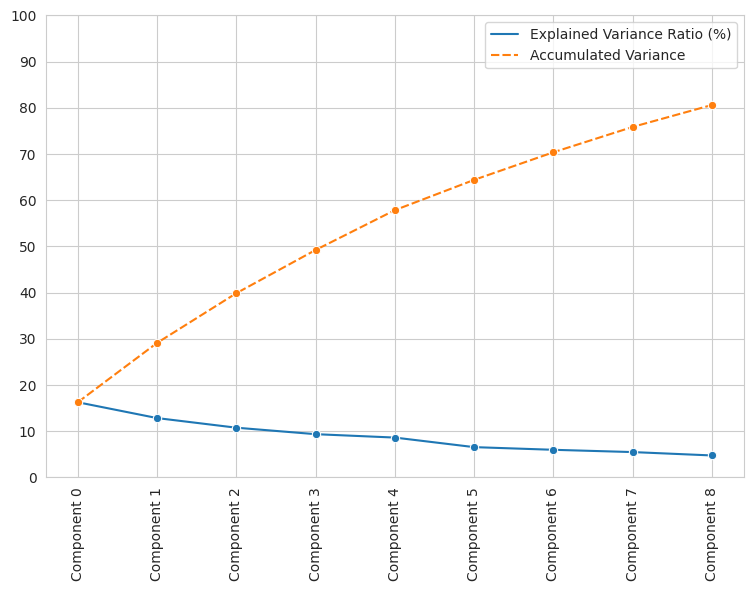

In [8]:
pca_component_analysis(game_data_pca, 9)

So we redefine our pipeline creation function to have 9 as the number of components.

In [9]:
def pipe_v2(thresh=0.7, clusters=50):
    pipe = pipe_v1(thresh=thresh, p_components=9, clusters=clusters)
    return pipe

Now we need to use the elbow method and look at silhouette scores.

---

## Section 3: Elbow method and Silhouette scores
The Elbow method and Silhouette scores will help us determine the appropriate number of clusters to use for our algorithm. We are also taking into account some domain knowledge, which is that eras in basketball range from 6 to 10 years. It is not a well defined concept so we don't have a hard number. Our dataset ranges from 1985 until 2023. So we (conservatively) expect there to be between 4 and 7 eras. We will rely on the recommendations based on these methods though.

In [10]:
new_pipe = pipe_v2()
pca_part_of_pipe = Pipeline(new_pipe.steps[:-1])
game_data_pca = pca_part_of_pipe.fit_transform(game_data)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


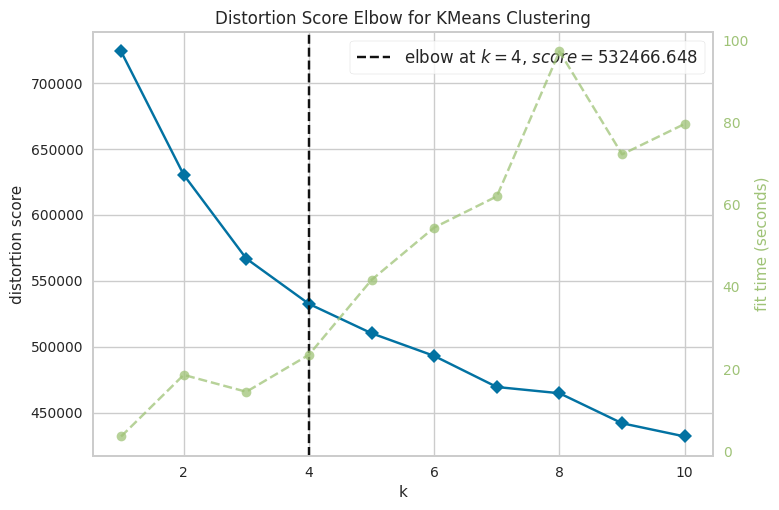

In [38]:
from yellowbrick.cluster import KElbowVisualizer


# This is from notebook 07 of the
# Churnometer walkthrough project.
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(1, 11))
visualizer.fit(game_data_pca)
visualizer.show()
plt.show()

They are suggesting 4 clusters, but 6 also looks promising. Let's see how the Silhouette scores behave with respect to these different numbers of clusters.

=== Average Silhouette Score for different number of clusters ===


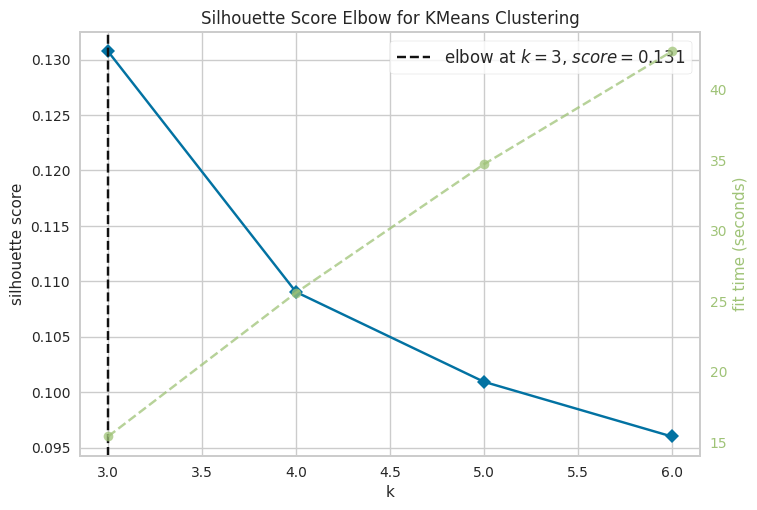



=== Silhouette plot for 3 Clusters ===


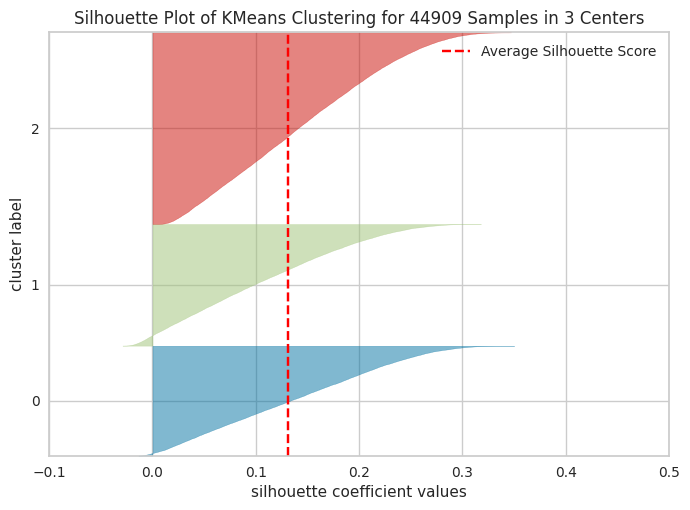



=== Silhouette plot for 4 Clusters ===


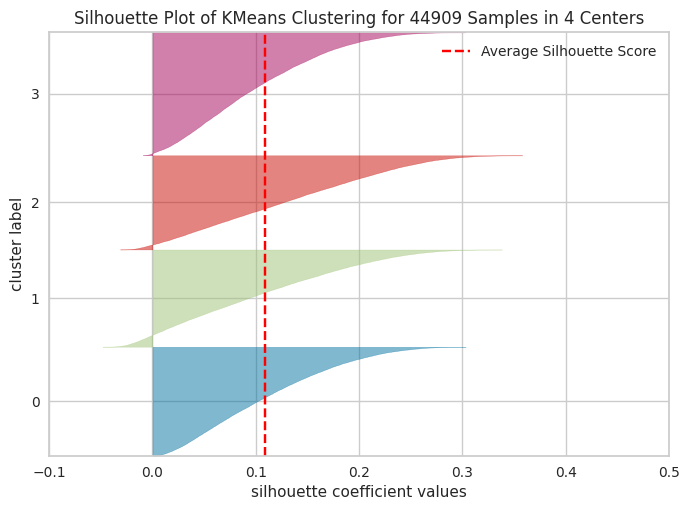



=== Silhouette plot for 5 Clusters ===


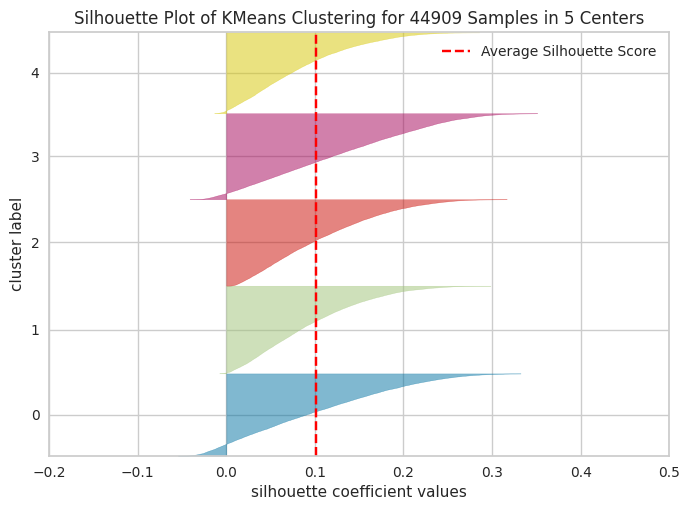



=== Silhouette plot for 6 Clusters ===


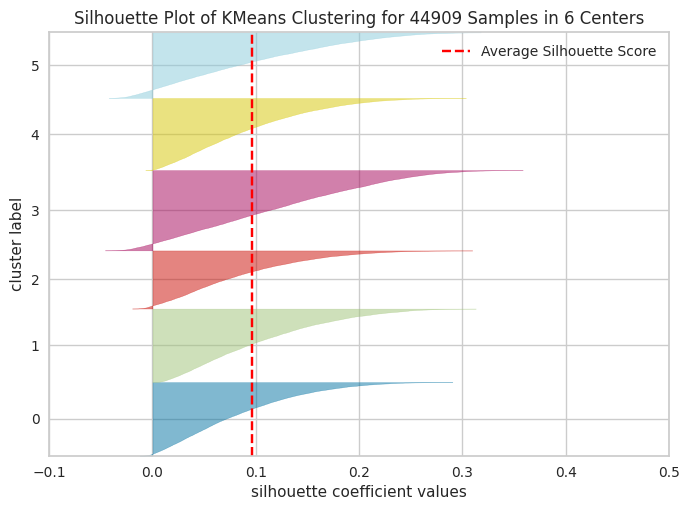

In [39]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start = 3
n_cluster_stop = 7

# This is from the notebook 07 of the 
# Churnometer walkthrough project.
print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(game_data_pca)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters,
                                                       random_state=42),
                                      colors='yellowbrick')
    visualizer.fit(game_data_pca)
    visualizer.show()
    plt.show()
    print("\n")



While the Elbow method suggests 4 clusters, analysis of the silhouette scores suggests using 3 clusters. We will go with 3 clusters. After adding the clustering data to the dataframe we will see if the clustering correlates with the `season` feature.

In [11]:
pipe_w_clusters = pipe_v2(clusters=3)
game_w_clusters = game_data.copy()

Now we will fit both of these pipelines and see what they tell us.

In [12]:
pipe_w_clusters.fit(game_w_clusters)

Pipeline(steps=[('corr_selector',
                 SmartCorrelatedSelection(selection_method='variance',
                                          threshold=0.7)),
                ('yeo_johnson',
                 YeoJohnsonTransformer(variables=['blk_home', 'oreb_away',
                                                  'fta_away', 'ast_home',
                                                  'pts_away', 'reb_away',
                                                  'pts_home', 'oreb_home'])),
                ('box_cox',
                 BoxCoxTransformer(variables=['ast_away', 'fta_home'])),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=9, random_state=42)),
                ('model', KMeans(n_clusters=3, random_state=42))])

Let's add the clustering data to the dataframe.

In [13]:
game_w_clusters['Clusters'] = pipe_w_clusters.predict(game_data)
game_w_clusters.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off,Clusters
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,41,92,0,3,9,18,16,28,44,25,...,40,21,11,7,17,19,100,0,0,1
28500006,39,88,0,2,26,41,20,28,48,17,...,42,19,7,7,18,32,108,0,0,1
28500010,39,88,0,1,40,49,17,40,57,23,...,41,27,10,7,20,32,116,1,0,1
28500011,42,82,0,2,24,38,10,24,34,30,...,47,23,10,7,19,28,112,0,0,1
28500008,36,91,0,4,33,52,18,29,47,17,...,44,26,11,3,22,40,119,0,0,1


* Cluster frequencies 
   Clusters
2      0.45
1      0.29
0      0.26 




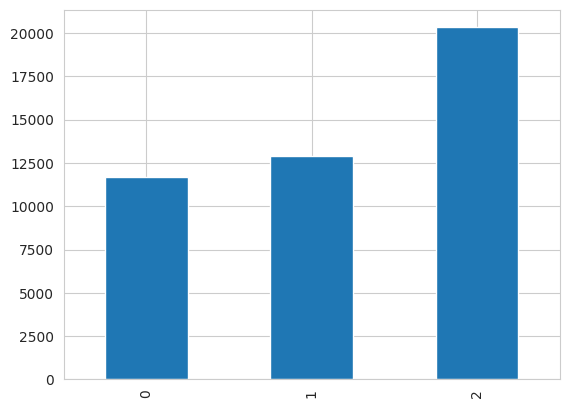

In [14]:
value_counts = game_w_clusters['Clusters'].value_counts(normalize=True)
value_counts = value_counts.to_frame().round(2)
print(f"* Cluster frequencies \n{value_counts} \n\n")
game_w_clusters['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

Let's add the season data back. We will see how the seasons are distributed across the clusters before training our classifcation model to get the profile of the individual clusters. Remember that the 1985-1986 season corresponds to 0 in the dataframe.

In [18]:
clusters_only = game_w_clusters.filter(['Clusters'])
try:
    season_clusters = clusters_only.join(game_seasons)
except ValueError as e:
    if "overlap" in str(e):
        print(str(e))
        print("This is likely being caused because we already performed this "
              "join.")
    else:
        raise e

(44909, 35)
(44909, 1)


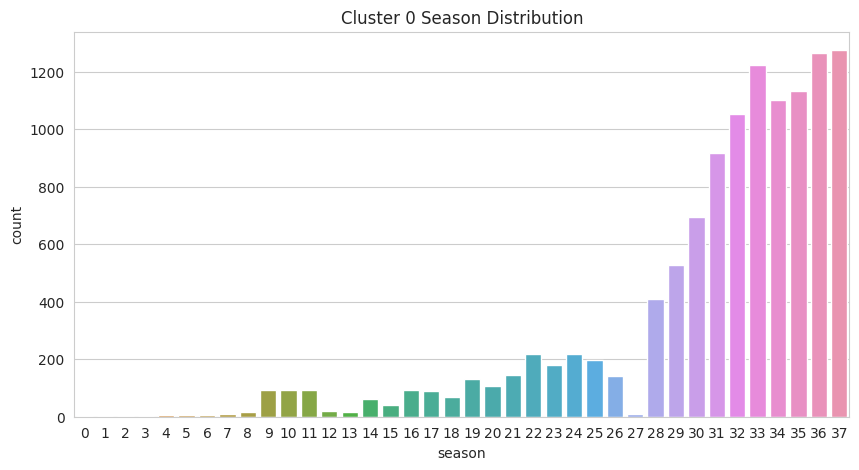

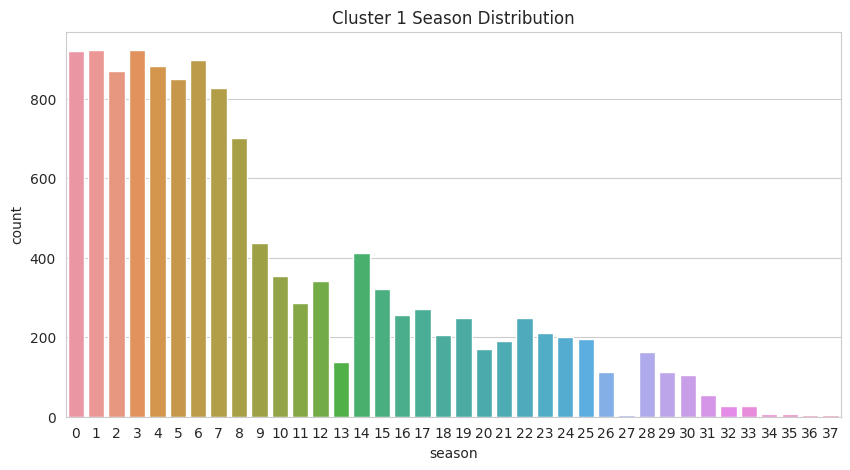

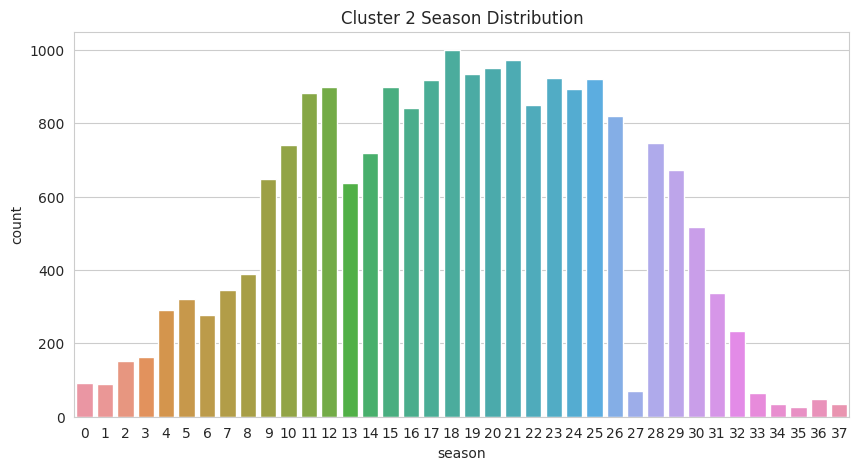

In [19]:

for i in range(3):
    cluster = season_clusters.query(f'Clusters == {i}')
    fig, ax = plt.subplots(figsize=(10, 5))
    title = f"Cluster {i} Season Distribution"
    sns.countplot(data=cluster, x="season").set_title(title)
    plt.show()

While this is just a graphical representation of the clusters with respect to season, it does seem to indicate a relationship with time. Let's look at the other correlations with respect to the clustering.

Note: The drop in the 27th season alerted us to an anomaly in our dataset. The raw data only has records from the playoffs for that season. This is unfortunate.

In [20]:
try:
    game_w_clusters = game_w_clusters.join(game_seasons)
except ValueError as e:
    if "overlap" in str(e):
        print(str(e))
        print("This is likely being caused because we already performed this "
              "join.")
    else:
        raise e

clusters_correlation = game_w_clusters.corr()
print(clusters_correlation['Clusters'].sort_values(key=lambda x: abs(x), 
                                                   ascending=False)[:8])

columns overlap but no suffix specified: Index(['season'], dtype='object')
This is likely being caused because we already performed this join.
Clusters     1.000000
pts_away    -0.539226
fga_away    -0.520310
fg3a_away   -0.508816
pts_home    -0.506554
fga_home    -0.500500
fg3a_home   -0.497897
fg3m_away   -0.472775
Name: Clusters, dtype: float64


Note that season is not among the most highly correlated features.
We will look at the correlation coefficients again when we attempt to classify the clusters using an Adaptive Boost model.

Let's investigate how the clusters and the components from the PCA relate to one another.

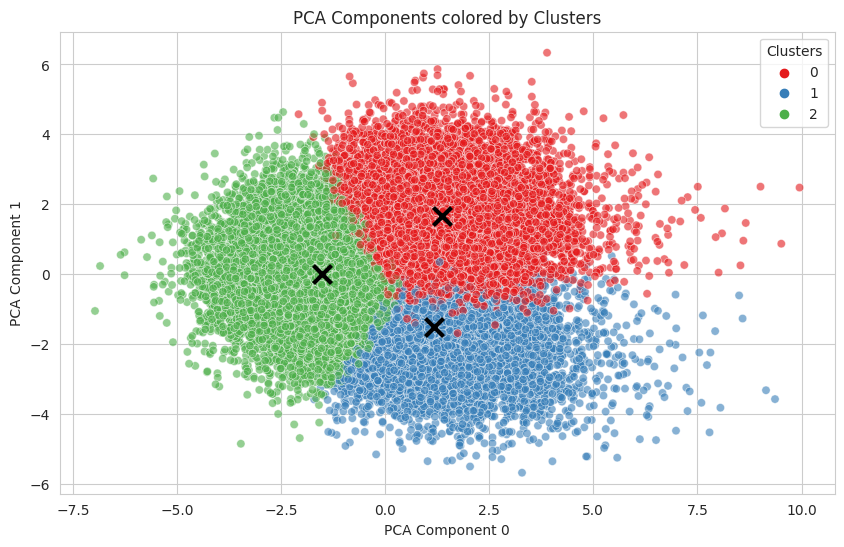

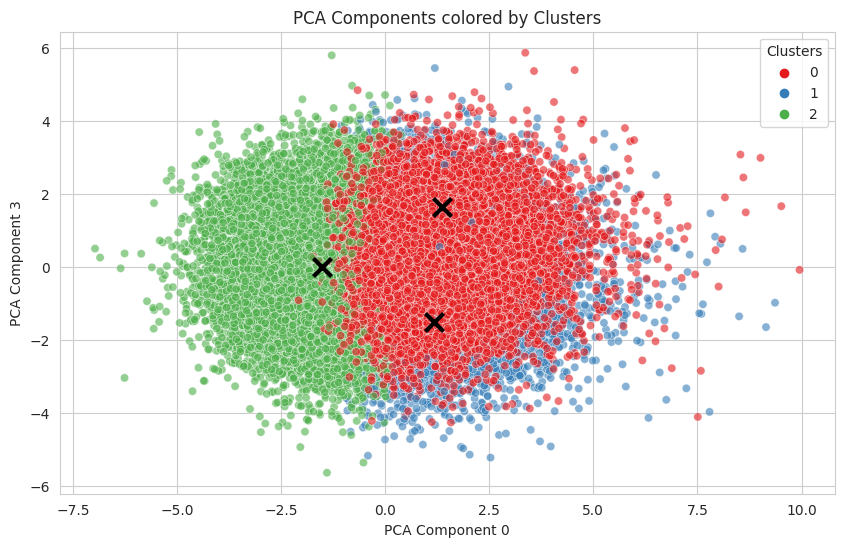

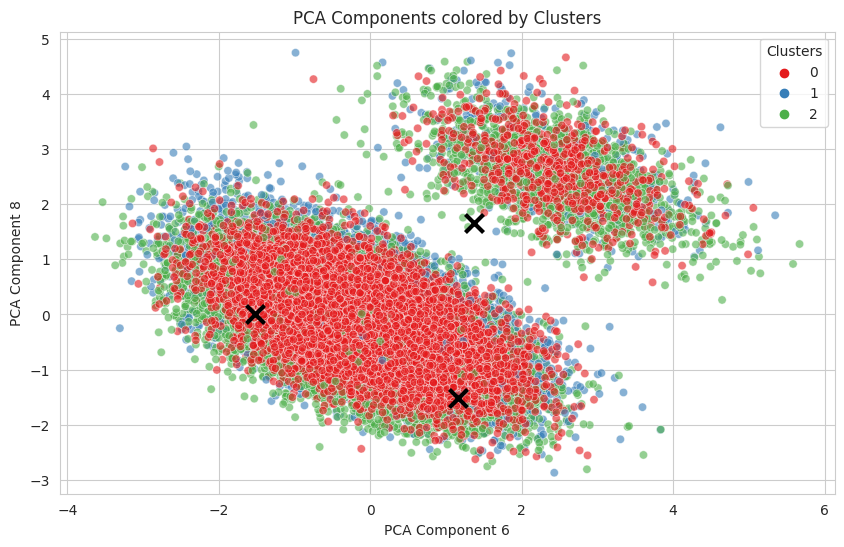

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")

# This is gotten from the Churnometer walkthrough project
def compare_components_w_clusters(a:int,b:int,pca_step,cluster_step,pipe):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_step[:, a], y=pca_step[:, b],
                hue=cluster_step['Clusters'], palette='Set1', alpha=0.6)
    plt.scatter(x=pipe['model'].cluster_centers_[:, 0],
            y=pipe['model'].cluster_centers_[:, 1],
            marker="x", s=169, linewidths=3, color="black")
    plt.xlabel(f"PCA Component {a}")
    plt.ylabel(f"PCA Component {b}")
    plt.title("PCA Components colored by Clusters")
    plt.show()

interesting_pairs = [(0,1), (0,3), (6,8)]
for a,b in interesting_pairs:
    compare_components_w_clusters(a, b, game_data_pca, game_w_clusters,
                                  pipe_w_clusters)


Feel free to look at how other components compare with respect to the clusters. We felt these three were the most interesting. However, only the first seems to relate the clusters to the components directly.

---

## Section 4: Cluster Profile
Next, we will determine the profile of these clusters. We do this by training a classification model on the data (with season added back in) with the clusters as the target. The important features of the models will help us to determine the profiles of the individual clusters.

In our model selection notebook, we found that Adaptive Boost and Logistic Regression were good models for working with this data. We will use Adaptive Boost as it works on multi-class classification problems without any need for adjustment.

In [22]:
df = game_w_clusters.copy()
cols = df.columns[df.isna().any()].tolist()
print(cols)

[]


In [23]:
from sklearn.model_selection import train_test_split


df = game_w_clusters.copy()
X_TrainSet, X_TestSet, y_TrainSet, y_TestSet = train_test_split(
                    df.drop(['Clusters'], axis=1),
                    df['Clusters'], test_size=0.2,
                    random_state=42)

print(X_TrainSet.shape)
print(X_TestSet.shape)

(35927, 34)
(8982, 34)


Now we create our classification pipeline. We will try it with the default parameters as well as the parameters we found in the last notebook.

In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel


def clf_pipe(thresh=0.7, params={}):
    pipe = Pipeline([
        ('corr_selector',
         SmartCorrelatedSelection(method="pearson",
                                  threshold=thresh,
                                  selection_method="variance"))
                        ])
    pipe.fit(X_TrainSet)
    dropping = pipe['corr_selector'].features_to_drop_
    new_assignments = { key: [val for val in value if val not in dropping] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}
    for transform, targets in new_assignments.items():
        if not targets:
            continue
        pipe.steps.append(
            (transform, TRANSFORMS[transform][0](variables=targets))
            )
    pipe.steps.append(('scaler', StandardScaler()))
    model = AdaBoostClassifier(random_state=42,**params)
    pipe.steps.append(("feat_selection", SelectFromModel(model)))
    pipe.steps.append(('model',model))
    return pipe

ada_thresh = 0.8
ada_params = {'n_estimators': 105, 'learning_rate': 1,
              'algorithm': 'SAMME.R'}

In [25]:
default_ada_pipe = clf_pipe()
default_ada_pipe.fit(X_TrainSet, y_TrainSet)

tuned_ada_pipe = clf_pipe(thresh=ada_thresh, params=ada_params)
tuned_ada_pipe.fit(X_TrainSet, y_TrainSet)

Pipeline(steps=[('corr_selector',
                 SmartCorrelatedSelection(selection_method='variance')),
                ('yeo_johnson',
                 YeoJohnsonTransformer(variables=['dreb_away', 'blk_home',
                                                  'oreb_away', 'fta_away',
                                                  'dreb_home', 'ast_home',
                                                  'stl_away', 'pts_away',
                                                  'stl_home', 'reb_away',
                                                  'pts_home', 'oreb_home',
                                                  'pf_away'])),
                ('box_cox',
                 BoxCoxTransformer(variables=['ast_away', 'fta_home'])),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(learning_rate=1,
                                                              n_estimators=105,
        

In [26]:
from sklearn.metrics import classification_report


print("Default AdaBoost:")
d_predicted_train = default_ada_pipe.predict(X_TrainSet)
d_predicted_test = default_ada_pipe.predict(X_TestSet)
print("### Train Set ##")
print(classification_report(y_TrainSet,d_predicted_train))
print("### Test Set ###")
print(classification_report(y_TestSet,d_predicted_test))
print("="*30)
print("="*30)
print("Tuned AdaBoost:")
t_predicted_train = tuned_ada_pipe.predict(X_TrainSet)
t_predicted_test = tuned_ada_pipe.predict(X_TestSet)
print("### Train Set ###")
print(classification_report(y_TrainSet,t_predicted_train))
print("### Test Set ###")
print(classification_report(y_TestSet,t_predicted_test))


Default AdaBoost:
### Train Set ##
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      9335
           1       0.91      0.87      0.89     10288
           2       0.92      0.94      0.93     16304

    accuracy                           0.91     35927
   macro avg       0.91      0.91      0.91     35927
weighted avg       0.91      0.91      0.91     35927

### Test Set ###
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2330
           1       0.91      0.87      0.89      2621
           2       0.91      0.94      0.92      4031

    accuracy                           0.91      8982
   macro avg       0.91      0.90      0.90      8982
weighted avg       0.91      0.91      0.91      8982

Tuned AdaBoost:
### Train Set ###
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      9335
           1       0.95      0.93      0.94

The performance of the models is similar on the training and test sets, so they are generalizing well. Both classifiers are good, but the one with the hyperparameters from the last notebook performs better. Let's look at what the important features are.

The following features were dropped: 
['fgm_home', 'fg3m_home', 'ftm_home', 'pf_home', 'fgm_away', 'fg3m_away', 'dreb_home', 'reb_home', 'stl_home', 'tov_home', 'plus_minus_home', 'ftm_away', 'dreb_away', 'reb_away', 'stl_away', 'blk_away', 'pf_away', 'home_wins', 'play_off']

* These are the 15 most important features in descending order. The model was trained on them: 
['fga_home', 'fg3a_home', 'oreb_home', 'fga_away', 'fg3a_away', 'fta_home', 'oreb_away', 'ast_home', 'pts_away', 'fta_away', 'ast_away', 'tov_away', 'season', 'blk_home', 'pts_home']


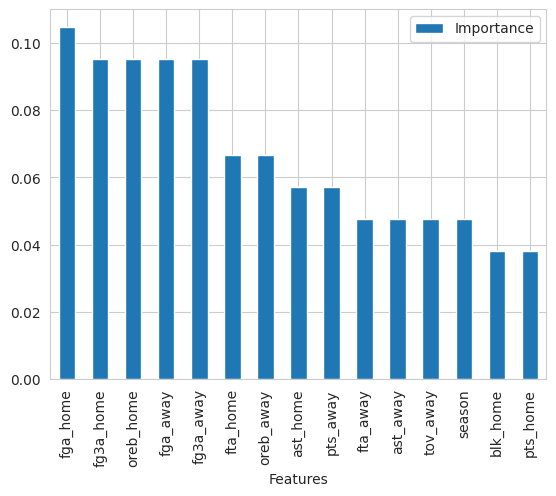

In [27]:
from src.notebook_functions import feature_importance_tree_based_models, find_features

kept, dropped = find_features(X_TrainSet, tuned_ada_pipe, initial_drop=[])
print(f"The following features were dropped: \n{dropped}")
print()
columns = X_TrainSet.filter(kept).columns
ada_model = tuned_ada_pipe['model']
feature_importance_tree_based_models(model=ada_model, columns=columns)
best_features = kept

It is interesting that attempted 3 points is so important to the clustering model. `season` has the fourth lowest importance among all features that the model used. We will use the following functions to determine the profile of the clusters. They are all from the Chrunometer walkthrough project.

In [30]:
import plotly.express as px


# All functions are from notebook 07 of the Churnometer walkthrough
def DescriptionAllClusters(df, decimal_points=3):

    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop(['Clusters'], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(
            f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = DescriptionAllClusters.append(
            ClusterDescription)

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):
    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
    # for a given cluster, iterate over all columns
    # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
    # if the variable is categorical, count the frequencies and displays the top 3 most frequent
    # That will show the most common levels for the category

    for col in EDA_Cluster.columns:
        try:  # eventually a given cluster will have only missing data for a given variable
            if EDA_Cluster[col].dtypes in ['float', 'int', 'int32']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.iloc[4, 0], decimal_points)
                Q3 = round(DescStats.iloc[6, 0], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description
            else:
                raise ValueError(f"Wrong data type for {col}: {EDA_Cluster[col].dtypes}.")
        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")
    ClustersDescription['Cluster'] = str(cluster)
    return ClustersDescription


def cluster_distribution_per_variable(df, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.value_counts(["Clusters", target]).reset_index()
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.show(renderer='jupyterlab')

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .groupby(level=0)
                   .apply(lambda x:  100*x / x.sum())
                   .reset_index()
                   .sort_values(by=['Clusters'])
                   )
    df_relative.columns = ['Clusters', target, 'Relative Percentage (%)']

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show(renderer='jupyterlab')


In [31]:
df_cluster_profile = df.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)

pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df_cluster_profile, decimal_points=0)
clusters_profile

,fga_home,fg3a_home,fta_home,oreb_home,ast_home,blk_home,pts_home,fga_away,fg3a_away,fta_away,oreb_away,ast_away,tov_away,pts_away,season
Cluster,,,,,,,,,,,,,,,
0,83.0 -- 92.0,24.0 -- 36.0,18.0 -- 28.0,8.0 -- 13.0,21.0 -- 28.0,3.0 -- 6.0,103.0 -- 119.0,83.0 -- 92.0,24.0 -- 36.0,17.0 -- 27.0,8.0 -- 13.0,21.0 -- 27.0,11.0 -- 16.0,102.0 -- 117.0,29.0 -- 35.0
1,83.0 -- 93.0,5.0 -- 15.0,24.0 -- 35.0,12.0 -- 18.0,22.0 -- 30.0,4.0 -- 8.0,103.0 -- 118.0,83.0 -- 93.0,5.0 -- 15.0,22.0 -- 33.0,11.0 -- 17.0,20.0 -- 27.0,13.0 -- 19.0,97.0 -- 112.0,3.0 -- 14.0
2,74.0 -- 83.0,11.0 -- 20.0,19.0 -- 30.0,9.0 -- 14.0,18.0 -- 25.0,3.0 -- 6.0,89.0 -- 103.0,74.0 -- 82.0,11.0 -- 20.0,19.0 -- 29.0,8.0 -- 13.0,17.0 -- 23.0,12.0 -- 18.0,86.0 -- 100.0,12.0 -- 24.0


There are many relevant features for the profiles of these clusters. We will drop all non-important features and refit the clustering and classification pipelines. Then we will look at this breakdown again and graph the distributions of these features with respect to the clusters.

## Refit Clustering
We now refit the clustering pipeline with the most relevant features determined by the profile in the last section. This will lead to a more focused model since it is only being trained on the features already determined to be most relevant to the clustering.

In [32]:
to_drop = [col for col in game_data.columns if col not in best_features]
new_assignments = { key: [val for val in value if val not in to_drop] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}
    
def last_cluster_pipe(clusters=3):
    pipe = Pipeline([('yeo_johnson',vt.YeoJohnsonTransformer(
                                    variables=new_assignments['yeo_johnson'])),
                                    ('box_cox',vt.BoxCoxTransformer(
                                    variables=new_assignments['box_cox'])),
                                    ('scaler', StandardScaler()),
                                    ('model', KMeans(n_clusters=3, 
                                                     random_state=42))])
    return pipe

game_data_reduced= game_data.copy().filter(best_features)
game_data_reduced.head()

,fga_home,fg3a_home,fta_home,oreb_home,ast_home,blk_home,pts_home,fga_away,fg3a_away,fta_away,oreb_away,ast_away,tov_away,pts_away
game_id,,,,,,,,,,,,,,
28500005,92,3,18,16,25,5,91,78,2,26,11,21,17,100
28500006,88,2,41,20,17,2,104,80,0,40,11,19,18,108
28500010,88,1,49,17,23,0,118,88,5,45,13,27,20,116
28500011,82,2,38,10,30,9,108,89,0,34,17,23,19,112
28500008,91,4,52,18,17,7,105,88,3,43,13,26,22,119


We redo the Elbow method and Silhoutte score analysis with this modified pipeline. Again, we are following the Churnometer project quite closely.

In [33]:
cluster_pipe = last_cluster_pipe()
pipeline_analysis = Pipeline(cluster_pipe.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(game_data_reduced)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


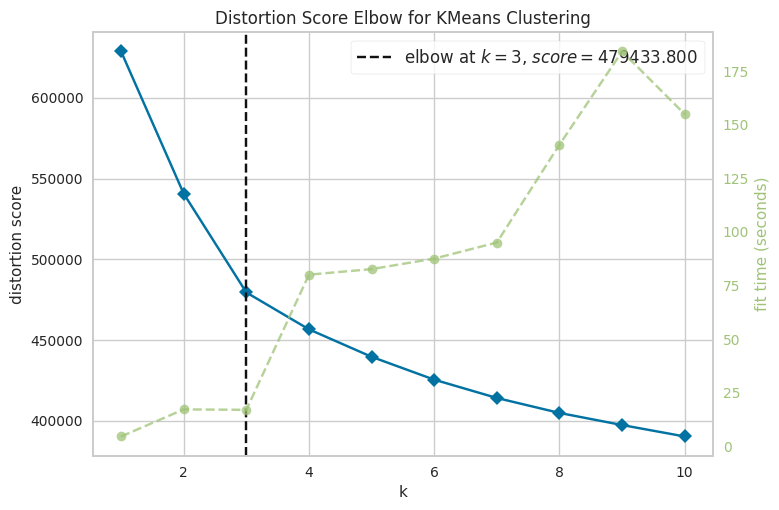

In [35]:
from yellowbrick.cluster import KElbowVisualizer

from yellowbrick.cluster import SilhouetteVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

We will save this plot for later.

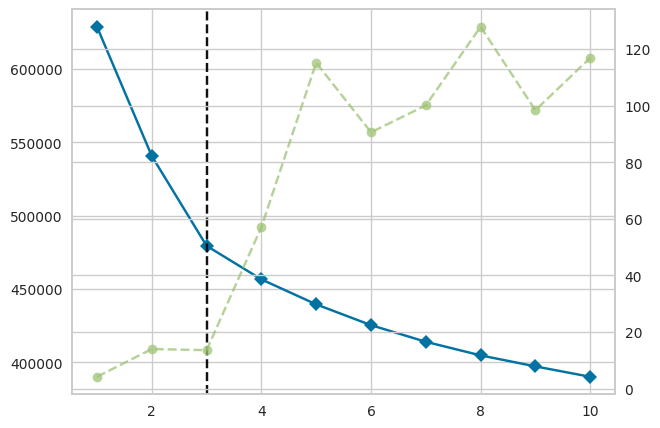

In [36]:
version = 'v1'
ml_dir = f'outputs/ml_pipeline/era_clusters/{version}'

try:
  os.makedirs(name=ml_dir)
except Exception as e:
  print(e)

fig, axes = plt.subplots(figsize=(7,5))
fig = KElbowVisualizer(KMeans(random_state=42), k=(1,11))
fig.fit(df_analysis)

plt.savefig(f"{ml_dir}/elbow.png", bbox_inches='tight',dpi=150)


=== Average Silhouette Score for different number of clusters ===


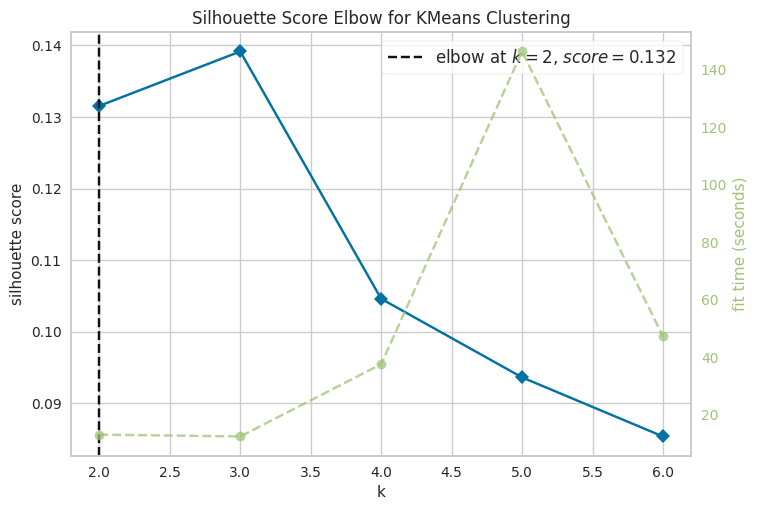



=== Silhouette plot for 2 Clusters ===


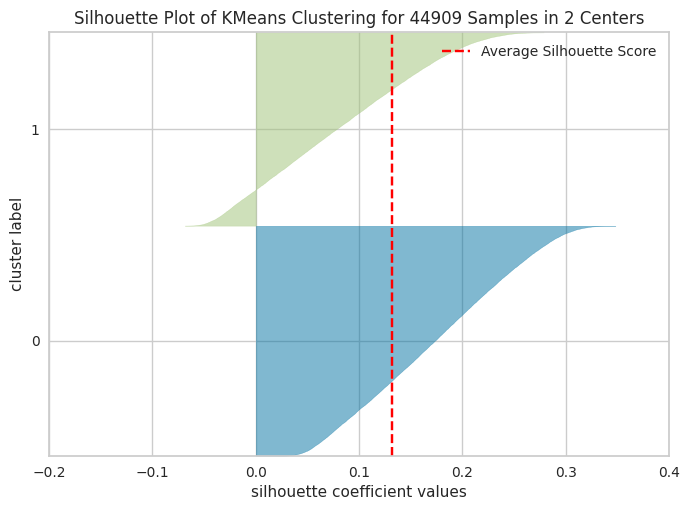



=== Silhouette plot for 3 Clusters ===


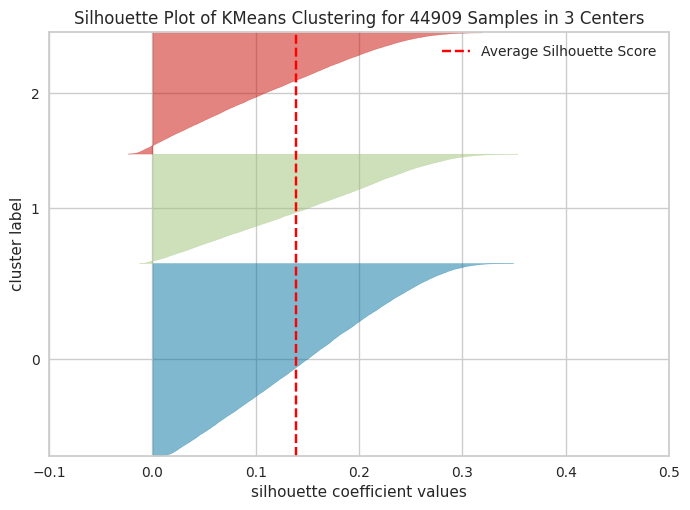



=== Silhouette plot for 4 Clusters ===


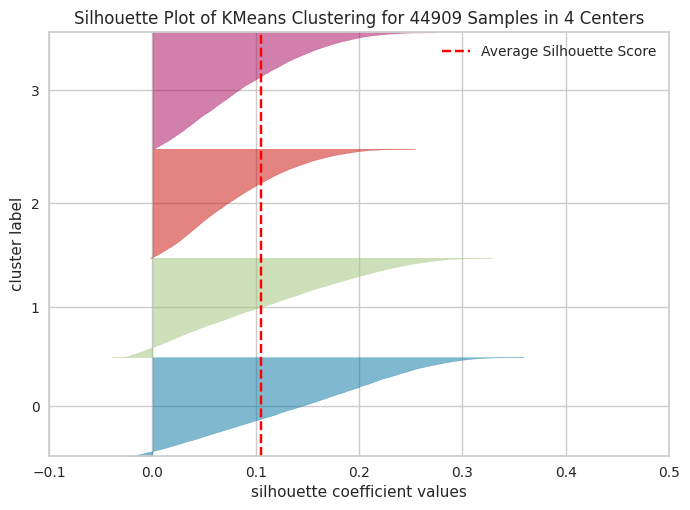



=== Silhouette plot for 5 Clusters ===


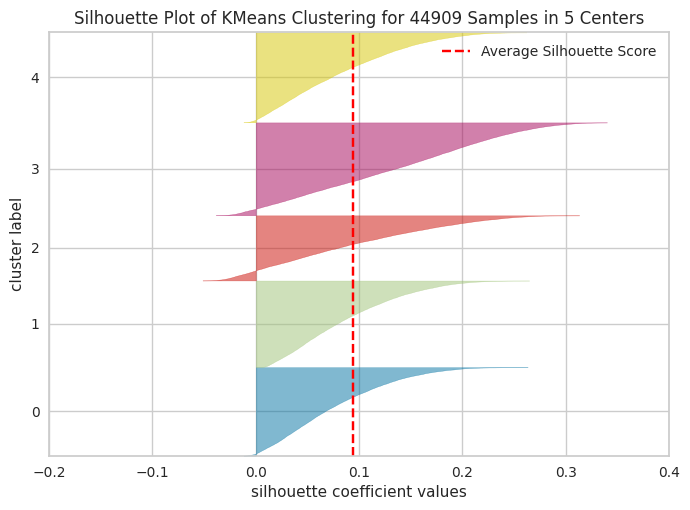



=== Silhouette plot for 6 Clusters ===


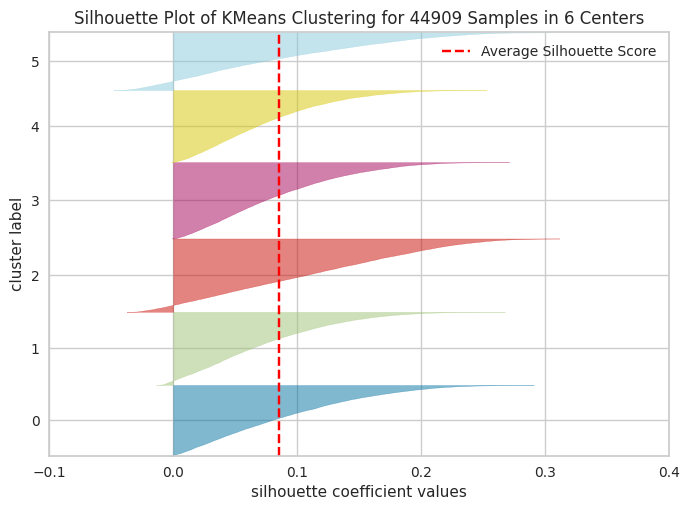

In [37]:
n_cluster_start, n_cluster_stop = 2, 7

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=42),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")


Again, 3 clusters gives the highest Silhoutte score.

In [55]:
new_game_w_clusters = game_data_reduced.copy()
last_pipe = last_cluster_pipe(clusters=3)
last_pipe.fit(new_game_w_clusters)
new_game_w_clusters["Clusters"] = last_pipe.predict(new_game_w_clusters)
save_df(new_game_w_clusters, "game_w_clusters", ml_dir)
new_game_w_clusters.head()

,fga_home,fg3a_home,fta_home,oreb_home,ast_home,blk_home,pts_home,fga_away,fg3a_away,fta_away,oreb_away,ast_away,tov_away,pts_away,Clusters
game_id,,,,,,,,,,,,,,,
28500005,92,3,18,16,25,5,91,78,2,26,11,21,17,100,2
28500006,88,2,41,20,17,2,104,80,0,40,11,19,18,108,2
28500010,88,1,49,17,23,0,118,88,5,45,13,27,20,116,2
28500011,82,2,38,10,30,9,108,89,0,34,17,23,19,112,2
28500008,91,4,52,18,17,7,105,88,3,43,13,26,22,119,2


Let's save our final cluster pipeline, look at the Silhouette scores again and save them for our streamlit app.

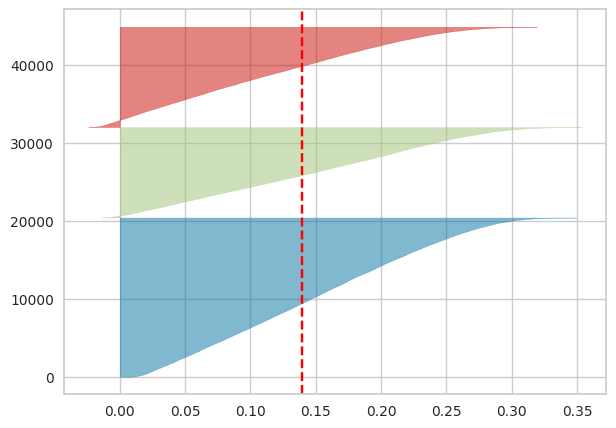

In [58]:
import joblib
# taken from Churnometer walkthrough project

joblib.dump(value=last_pipe, filename=f"{ml_dir}/cluster_pipeline.pkl")

# from Churnometer notebook on clustering
fig, axes = plt.subplots(figsize=(7,5))
fig = SilhouetteVisualizer(Pipeline(last_pipe.steps[-1:])[0] , colors='yellowbrick', ax=axes)
fig.fit(df_analysis)

plt.savefig(f"{ml_dir}/clusters_silhouette.png", bbox_inches='tight',dpi=150)



In [71]:

val_counts = new_game_w_clusters['Clusters'].value_counts(normalize=True)
val_counts = val_counts.to_frame().round(2)
print(f"* Cluster frequencies \n{val_counts} \n\n")
print("frequency computed")
new_game_w_clusters['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

new_clusters_only = new_game_w_clusters.filter(['Clusters'])
try:
    new_season_clusters = new_clusters_only.join(game_seasons)
except ValueError as e:
    if "overlap" in str(e):
        print(str(e))
        print("This is likely being caused because we already performed this "
              "join.")
    else:
        raise e

try:
    new_game_w_clusters = new_game_w_clusters.join(game_seasons)
except ValueError as e:
    if "overlap" in str(e):
        print(str(e))
        print("This is likely being caused because we already performed this "
              "join.")|
    else:
        raise e

save_df(new_season_clusters, "season_by_cluster", ml_dir)
print(new_season_clusters.corr())
print("new)")

SyntaxError: invalid syntax (2538089713.py, line 25)

Lets look at the distribution of seasons for each cluster like we did previously. We will compare it side by side with the old distribution. Note, the labels of the clusters have likely changed. You may need to edit `pairs`.

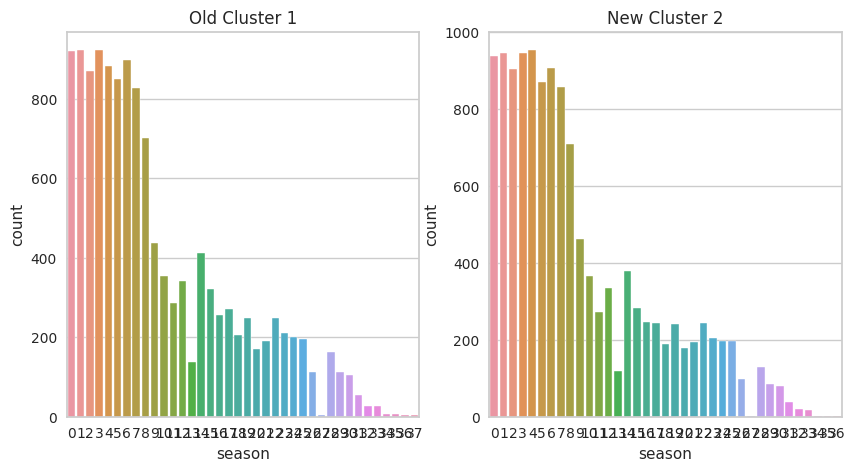

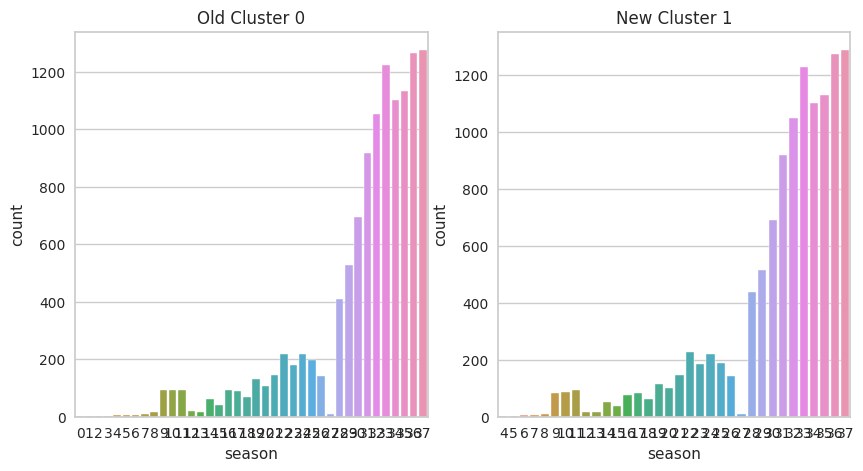

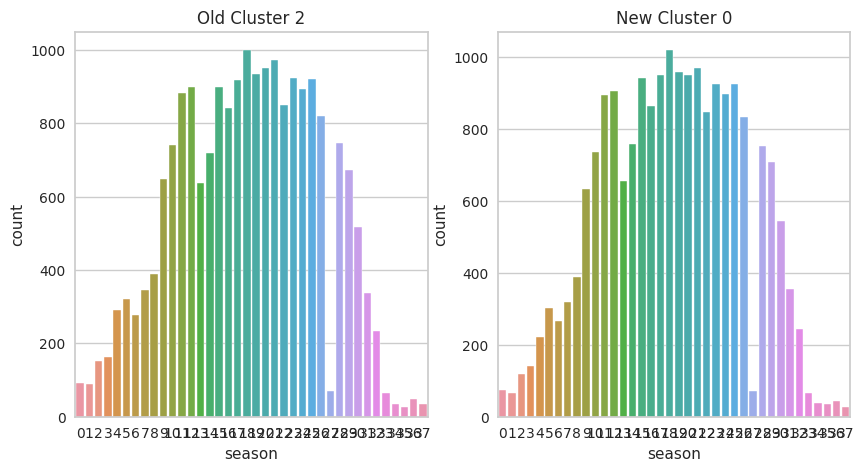

In [72]:
pairs = [(1,2),(0,1),(2,0)]
for i,j in pairs:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    old_cluster = season_clusters.query(f'Clusters == {i}')
    new_cluster = new_season_clusters.query(f'Clusters == {j}')
    sns.countplot(data=old_cluster, x="season", ax=ax[0]).set_title(f"Old Cluster {i}")
    sns.countplot(data=new_cluster, x="season", ax=ax[1]).set_title(f"New Cluster {j}")
    plt.show()


Now we use a confusion matrix to compare the two different clusterings. Recall how the labelling has changed, this means that we may have many large values off of the diagonal. This is not a cause for alarm.

In [73]:
from sklearn.metrics import confusion_matrix

new_predictions = new_game_w_clusters['Clusters']
old_predictions = game_w_clusters['Clusters']

print(confusion_matrix(new_predictions,old_predictions))

[[  395  1066 18978]
 [10980   179   442]
 [  290 11664   915]]


The clusters have moved a bit, but not too much (if you take the relabelling into account). Let's retrain the classification pipeline on this clustering.

In [74]:
df = new_game_w_clusters.copy()
X_TrainSet, X_TestSet, y_TrainSet, y_TestSet = train_test_split(
                    df.drop(['Clusters'], axis=1),
                    df['Clusters'], test_size=0.2,
                    random_state=42)

print(X_TrainSet.shape)
print(X_TestSet.shape)

train_dir = 'datasets/train/clustering'
save_df(X_TrainSet, 'X_TrainSet', train_dir, index=True)
save_df(y_TrainSet, 'y_TrainSet', train_dir, index=True)

test_dir = 'datasets/test/clustering'
save_df(X_TestSet, 'X_TestSet', test_dir, index=True)
save_df(y_TestSet, 'y_TestSet', test_dir, index=True)


(35927, 15)
(8982, 15)


Just to remind you, these are the input for the pipeline.

In [63]:
to_drop = [col for col in game_data.columns if col not in best_features]
print(to_drop)
new_assignments = { key: [val for val in value if val not in to_drop] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}


['fgm_home', 'fg3m_home', 'ftm_home', 'dreb_home', 'reb_home', 'stl_home', 'tov_home', 'pf_home', 'plus_minus_home', 'fgm_away', 'fg3m_away', 'ftm_away', 'dreb_away', 'reb_away', 'stl_away', 'blk_away', 'pf_away', 'home_wins', 'play_off']


In [64]:
ada_params = {'n_estimators': 110, 'learning_rate': 1.133,
              'algorithm': 'SAMME.R'}

def last_clf_pipe():
    model = AdaBoostClassifier(random_state=42,**ada_params)
    pipe = Pipeline([('yeo_johnson',vt.YeoJohnsonTransformer(
                                    variables=new_assignments['yeo_johnson'])),
                                    ('box_cox',vt.BoxCoxTransformer(
                                    variables=new_assignments['box_cox'])),
                                    ('scaler', StandardScaler()),
                                    ('model', model)])
    return pipe

    
last_ada_pipe = last_clf_pipe()
last_ada_pipe.fit(X_TrainSet, y_TrainSet)

print("Adaptive Boost Classifier:")
predicted = last_ada_pipe.predict(X_TestSet)
print(classification_report(y_TestSet,predicted))

Adaptive Boost Classifier:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4068
           1       0.97      0.97      0.97      2300
           2       0.95      0.96      0.96      2614

    accuracy                           0.96      8982
   macro avg       0.96      0.96      0.96      8982
weighted avg       0.96      0.96      0.96      8982



This is performing even better than it did previously. We will look again at the importance of different features before looking at the profile of the clusters.

Old importance levels
* These are the 15 most important features in descending order. The model was trained on them: 
['fga_home', 'fg3a_home', 'oreb_home', 'fga_away', 'fg3a_away', 'fta_home', 'oreb_away', 'ast_home', 'pts_away', 'fta_away', 'ast_away', 'tov_away', 'season', 'blk_home', 'pts_home']


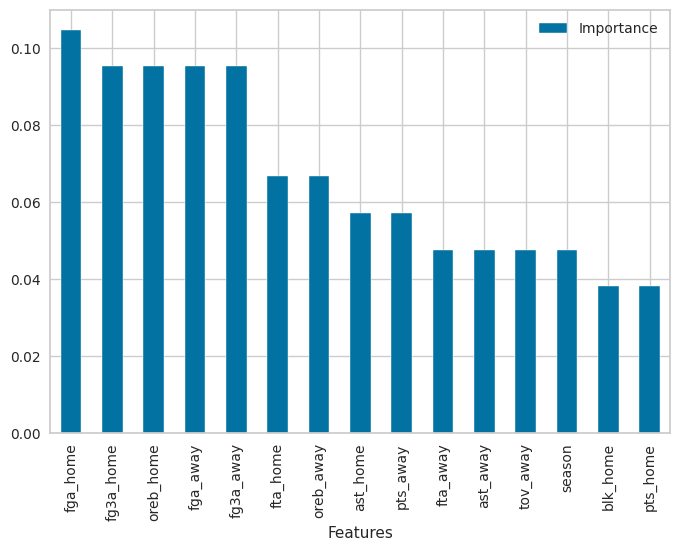

New importance levels
* These are the 15 most important features in descending order. The model was trained on them: 
['fg3a_home', 'fg3a_away', 'fga_home', 'oreb_away', 'fta_home', 'ast_home', 'pts_home', 'fga_away', 'pts_away', 'oreb_home', 'ast_away', 'fta_away', 'blk_home', 'tov_away', 'season']


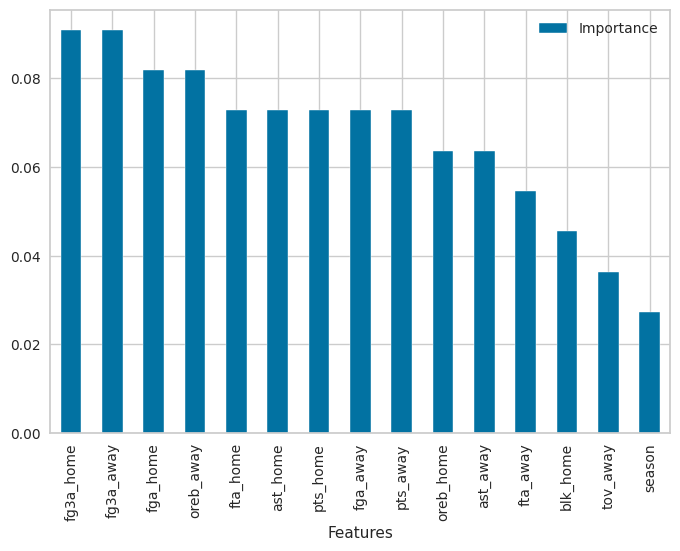

In [65]:
print("Old importance levels")
old_ada_model = tuned_ada_pipe['model']
feature_importance_tree_based_models(model=old_ada_model,columns=best_features)
print("New importance levels")
ada_model = last_ada_pipe['model']
feature_importance_tree_based_models(model=ada_model, columns=best_features)

Now 3 point attempts are the most important feature. Let's look at the full profile of the clusters.

In [66]:
#cluster_distribution_per_variable(df, target):
df_cluster_profile = new_game_w_clusters.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)

pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df_cluster_profile, decimal_points=0)
#base_cols = [feat.split('_'[0])]
base_cols = set()
for col in clusters_profile.columns:
    if '_' in col:
        base_cols.add(col.split('_')[0])
    else:
        print(col)
        base_cols.add(col)
sorted_cols = []
base_cols = sorted(list(base_cols))
start_letters = {'f','p'}
for col in base_cols:
    if col[0] in start_letters:
        sorted_cols.append(col + "_home")
        sorted_cols.append(col + "_away")

base_cols = [col for col in base_cols if col[0] not in start_letters]
for col in base_cols:
    if col == "season":
        sorted_cols.append(col)
    else:
        sorted_cols.append(col + "_home")
        sorted_cols.append(col + "_away")

clusters_profile = clusters_profile.filter(sorted_cols)
save_df(clusters_profile, "clusters_profile", ml_dir)
clusters_profile

season


,fg3a_home,fg3a_away,fga_home,fga_away,fta_home,fta_away,pts_home,pts_away,ast_home,ast_away,blk_home,oreb_home,oreb_away,season,tov_away
Cluster,,,,,,,,,,,,,,,
0,11.0 -- 20.0,11.0 -- 20.0,74.0 -- 83.0,74.0 -- 83.0,19.0 -- 30.0,19.0 -- 29.0,88.0 -- 102.0,85.0 -- 99.0,18.0 -- 24.0,16.0 -- 23.0,3.0 -- 7.0,9.0 -- 14.0,8.0 -- 13.0,13.0 -- 24.0,12.0 -- 18.0
1,24.0 -- 36.0,25.0 -- 36.0,83.0 -- 92.0,83.0 -- 92.0,18.0 -- 28.0,17.0 -- 27.0,104.0 -- 119.0,102.0 -- 117.0,22.0 -- 28.0,21.0 -- 27.0,3.0 -- 6.0,8.0 -- 13.0,7.0 -- 13.0,29.0 -- 35.0,11.0 -- 16.0
2,5.0 -- 14.0,5.0 -- 14.0,82.0 -- 93.0,82.0 -- 93.0,24.0 -- 36.0,22.0 -- 33.0,104.0 -- 118.0,99.0 -- 113.0,23.0 -- 30.0,20.0 -- 27.0,4.0 -- 8.0,11.0 -- 17.0,11.0 -- 17.0,3.0 -- 14.0,13.0 -- 19.0


There are many features where two clusters have almost identical ranges. We have isolated the features where the distribution over each cluster has minimal overlap.

In [67]:
small_profile = clusters_profile.filter(['fg3a_home','fg3a_away','season'])

small_profile

,fg3a_home,fg3a_away,season
Cluster,,,
0,11.0 -- 20.0,11.0 -- 20.0,13.0 -- 24.0
1,24.0 -- 36.0,25.0 -- 36.0,29.0 -- 35.0
2,5.0 -- 14.0,5.0 -- 14.0,3.0 -- 14.0


Thus, the cleanest profile of each of the clusters is:
* **Cluster 0**: Both teams attempted a moderate number of 3 point shots, and the games took place between the 1997-1998 season and the 2009-2010 season.
* **Cluster 1**: Both teams attempted a small number of 3 point shots, and the games took place between the 1988-1989 season and the 1999-2000 season.
"* **Cluster 2**: Both teams attempted a large number of 3 point shots and the games occurred between the 2014-2015 and 2019-2020 season.\n"

It is not concerning that some seasons are not present. This is because we computed these profiles by looking at the distribution of the features across the clusters and got the range of values by looking at the first and third quartile. This result confirms Hypothesis 4, that the seasons can be seen from the statistics. The breakdown of the 3 point statistics over the clusters also lines up with what we saw in our exploratory data analysis about the relationship between 3 pointers and Year.

Let's look at the distribution of each feature colored by cluster.

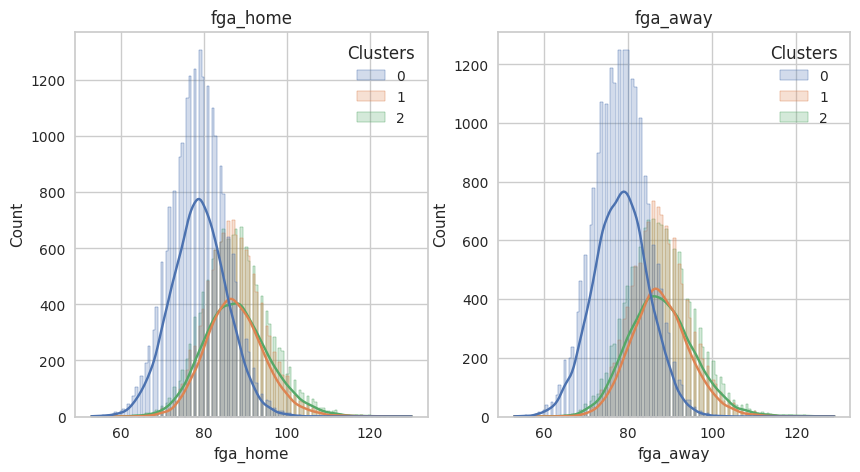

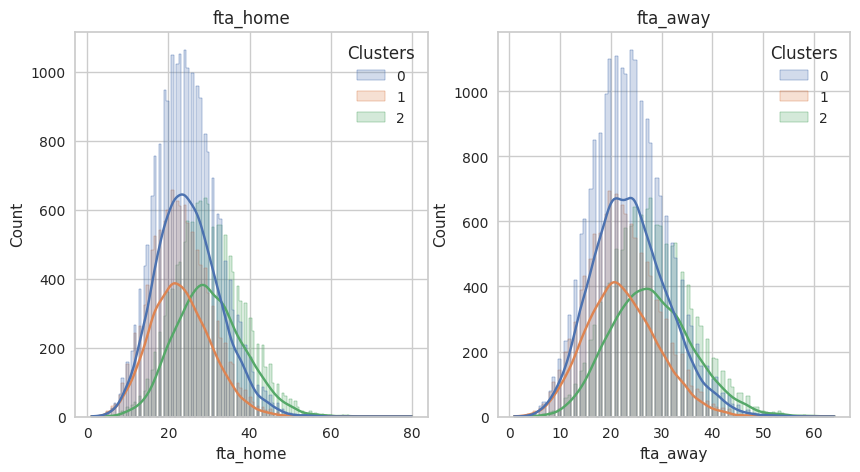

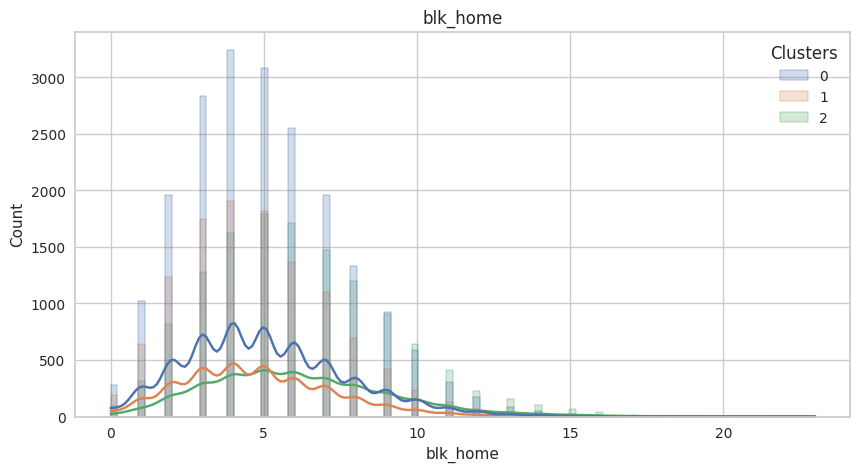

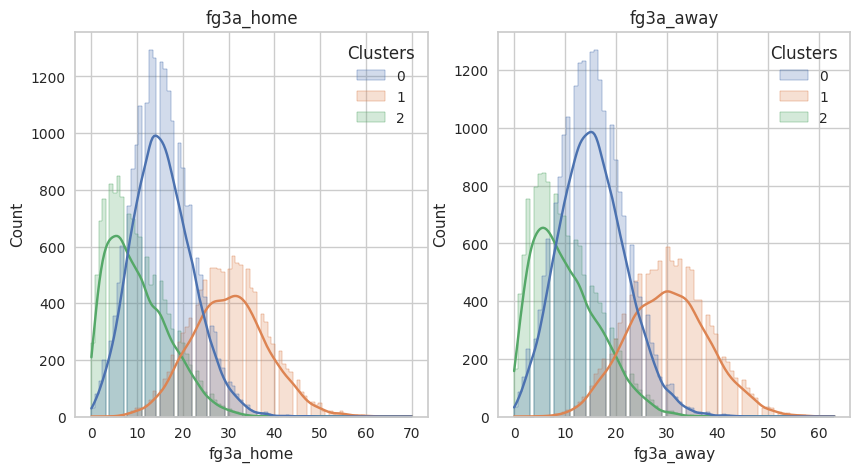

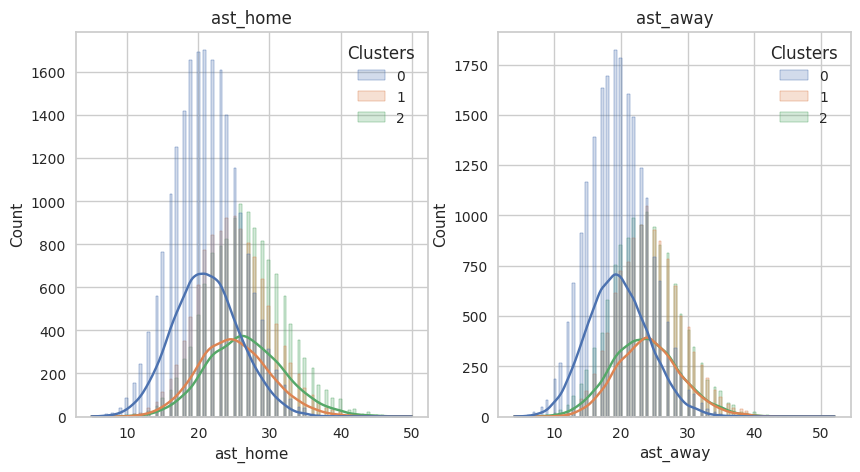

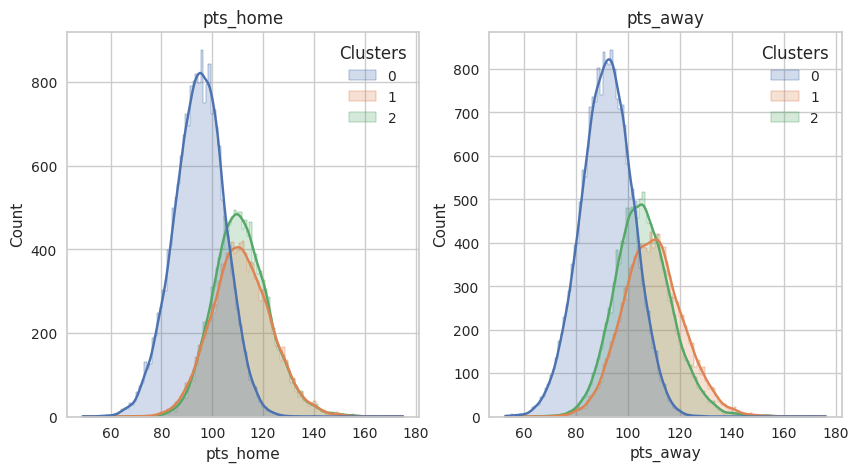

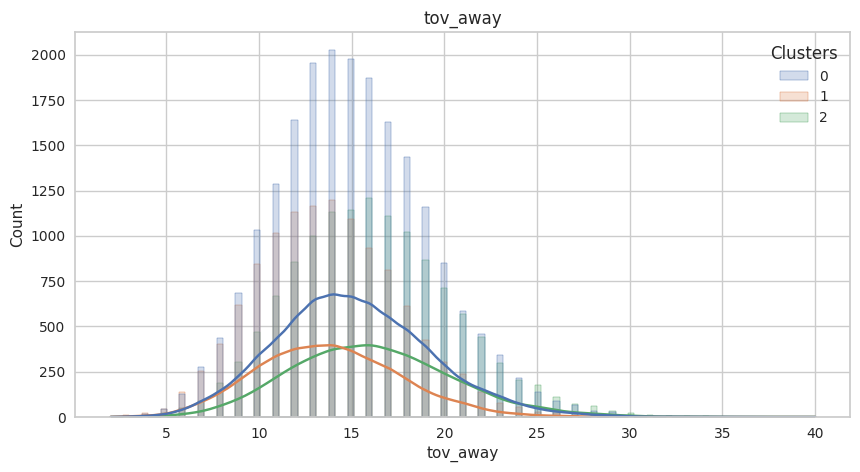

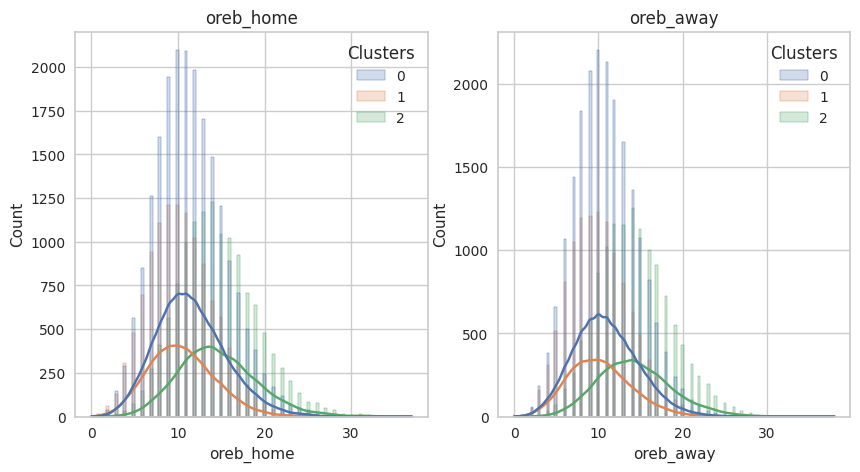

In [68]:
feature_pairs = []
feature_stems = list({term.split('_')[0] for term in best_features})
for stem in feature_stems:
    home_stem = stem + '_home'
    away_stem = stem + '_away'
    if home_stem in best_features and away_stem in best_features:
        feature_pairs.append((home_stem, away_stem))
    elif home_stem in best_features:
        feature_pairs.append((home_stem, ''))
    elif away_stem in best_features:
        feature_pairs.append(('',away_stem))

for home, away in feature_pairs:
    if home and away:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        sns.histplot(data=df, x=home, kde=True, element="step", ax=axes[0],
                     hue='Clusters',palette='deep')
        sns.histplot(data=df, x=away, kde=True, element="step", ax=axes[1],
                     hue='Clusters', palette='deep')
        axes[0].set_title(f'{home}')
        axes[1].set_title(f'{away}')
        plt.show()
    elif home:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        sns.histplot(data=df, x=home, kde=True, element="step", ax=axes,
                     hue='Clusters', palette='deep')
        axes.set_title(f'{home}')
        plt.show()
    elif away:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        sns.histplot(data=df, x=away, kde=True, element="step", ax=axes,
                     hue='Clusters', palette='deep')
        axes.set_title(f'{away}')
        plt.show()

We see in these distributions the grouping mentioned above. Very frequently, a feature will have the same distributions over two clusters. It is a testiment to the model that it is still able to distinguish between these clusters so well.

In [69]:
# taken from Churnometer walkthrough project
import joblib


joblib.dump(value=last_ada_pipe, 
            filename=f"{ml_dir}/clf_pipeline.pkl")


['outputs/ml_pipeline/era_clusters/v1/clf_pipeline.pkl']


---

## Conclusion
After training a model to classify the clusters, and refitting everything, we found that while season is not one of the most important features  of the classification model, it is one of 3 features that distinguishes the clusters. This confirms Hypothesis 4 and satisfies Business Requirement 3. The fact that season is not important is an even stronger indication that the eras can be detected purely statistically.

This is our final notebook.
